In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

from utils import get_data

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X, y, metadata, variables = get_data('dry_bean_dataset')

In [3]:
y.value_counts(normalize=True)

Class   
DERMASON    0.260525
SIRA        0.193667
SEKER       0.148924
HOROZ       0.141650
CALI        0.119756
BARBUNYA    0.097127
BOMBAY      0.038351
Name: proportion, dtype: float64

In [4]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [5]:
idx = variables['type'].isin(['Integer', 'Continuous'])
num_cols = variables.loc[idx, 'name']
num_cols = num_cols.loc[~num_cols.isin(y.columns.tolist())]
num_cols

0                Area
1           Perimeter
2     MajorAxisLength
3     MinorAxisLength
4         AspectRatio
5        Eccentricity
6          ConvexArea
7       EquivDiameter
8              Extent
9            Solidity
10          Roundness
11        Compactness
12       ShapeFactor1
13       ShapeFactor2
14       ShapeFactor3
15       ShapeFactor4
Name: name, dtype: object

In [6]:
idx = variables['type'].isin(['Binary', 'Categorical'])
cat_cols = variables.loc[idx, 'name']
cat_cols = cat_cols.loc[~cat_cols.isin(y.columns)]
cat_cols

Series([], Name: name, dtype: object)

# Train the Expectation Maximisation

In [7]:
RANDOM_STATE = 42
N_JOBS = -1
VERBOSE = 4

# clus = GaussianMixture(n_init=100, init_params='k-means++', random_state=RANDOM_STATE, covariance_type='full')
scaler = StandardScaler()
clus = GaussianMixture(random_state=RANDOM_STATE)
clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('model', clus)
])


In [8]:
# clus_pipeline.set_params(model__n_components=3)
# clus_pipeline.fit(X_train)
# clus_pipeline.named_steps['model'].means_
# clus_pipeline.named_steps['model'].score(X_train)

In [9]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)
    
    results[n_components] = {'aic': clus_pipeline.named_steps['model'].aic(X_train.values),
                             'bic': clus_pipeline.named_steps['model'].bic(X_train.values),
                             'score': clus_pipeline.named_steps['model'].score(X_train.values),
                           }

---------- n_components: 2 ----------


---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


<Axes: title={'center': 'GMM BIC - Dry Beans'}, xlabel='n_components'>

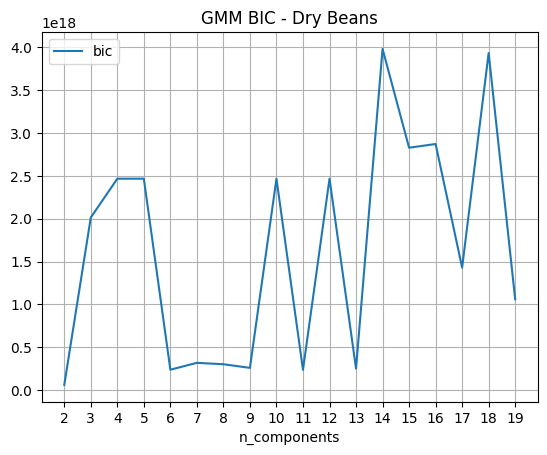

In [10]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic', 'score']
results_df.plot(x='n_components', y='bic',title='GMM BIC - Dry Beans', xticks=results_df['n_components'], grid=True)

<Axes: title={'center': 'score'}, xlabel='n_components'>

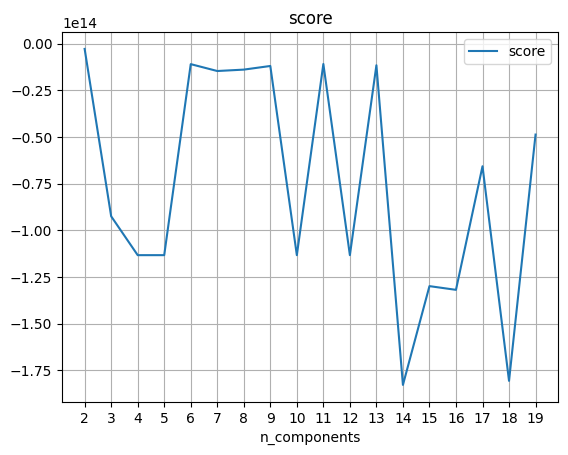

In [12]:
results_df.plot(x='n_components', y='score',title='score', xticks=results_df['n_components'], grid=True)

In [11]:
clus_pipeline.set_params(model__n_components=4)
label = clus_pipeline.fit_predict(X_train)
print(label.shape)

means = clus_pipeline.named_steps['model'].means_
covariances = clus_pipeline.named_steps['model'].covariances_
weights = clus_pipeline.named_steps['model'].weights_

w_factor = 0.4 / weights.max()

(10888,)


In [12]:
X_std = StandardScaler().fit_transform(X_train)

Text(0, 0.5, 'Permimeter')

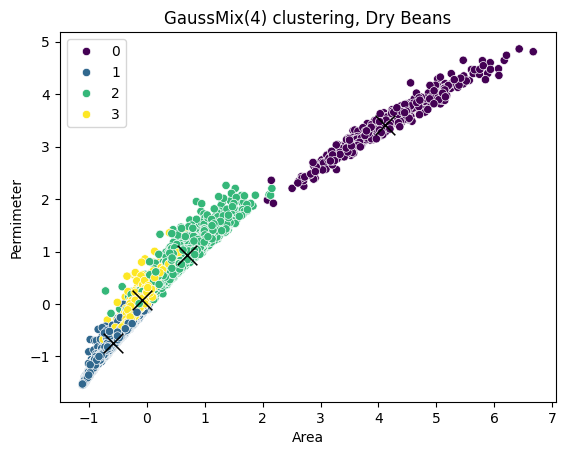

In [19]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_std[:,0], y=X_std[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=means[:,0], y=means[:,1], color='black', s=200, marker='x', ax=ax)

# for pos, covar, w in zip(means, covariances, weights):
#         draw_ellipse(pos, covar, alpha=w * w_factor)

ax.set_title("GaussMix(4) clustering, Dry Beans")
ax.set_xlabel("Area")
ax.set_ylabel("Permimeter")


In [13]:
X.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRatio', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'Roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')